<a href="https://colab.research.google.com/github/alexander-toschev/cv-course/blob/main/FD_PointsAndPatches_HARRIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Harris Corner Detection

One early attempt to find these corners was done by Chris Harris & Mike Stephens in their paper A Combined Corner and Edge Detector in 1988, so now it is called Harris Corner Detector. He took this simple idea to a mathematical form. It basically finds the difference in intensity for a displacement of (u,v) in all directions. This is expressed as below:

E(u,v) = $\sum_{x,y} \underbrace{w(x,y)}_\text{window function} \, [\underbrace{I(x+u,y+v)}_\text{shifted intensity}-\underbrace{I(x,y)}_\text{intensity}]^2$

Window function is either a rectangular window or gaussian window which gives weights to pixels underneath.

We have to maximize this function E(u,v) for corner detection. That means, we have to maximize the second term. Applying Taylor Expansion to above equation and using some mathematical steps (please refer any standard text books you like for full derivation), we get the final equation as:

E(u,v) $\approx$ \begin{bmatrix} u & v \end{bmatrix} M \begin{bmatrix} u \\ v \end{bmatrix}

where

M = \sum_{x,y} w(x,y) \begin{bmatrix}I_x I_x & I_x I_y \\
                                     I_x I_y & I_y I_y \end{bmatrix}

Here, $I_x$ and $I_y$ are image derivatives in x and y directions respectively. (Can be easily found out using cv2.Sobel()).

Then comes the main part. After this, they created a score, basically an equation, which will determine if a window can contain a corner or not.


$R = det(M) - k(trace(M))^2$

where
$det(M) = \lambda_1 \lambda_2$
$trace(M) = \lambda_1 + \lambda_2$
$\lambda_1$ and $\lambda_2$ are the eigen values of M
So the values of these eigen values decide whether a region is corner, edge or flat.

When |R| is small, which happens when $\lambda_1$ and $\lambda_2$ are small, the region is flat.
When R<0, which happens when $\lambda_1 >> \lambda_2$ or vice versa, the region is edge.
When R is large, which happens when \lambda_1 and \lambda_2 are large and $\lambda_1 \sim \lambda_2$, the region is a corner.



OpenCV has the function cv2.cornerHarris() for this purpose. Its arguments are :

img - Input image, it should be grayscale and float32 type.

blockSize - It is the size of neighbourhood considered for corner detection

ksize - Aperture parameter of Sobel derivative used.

k - Harris detector free parameter in the equation.


In [7]:
!wget https://w7.pngwing.com/pngs/710/895/png-transparent-chessboard-mathematics-board-game-chess-game-symmetry-black.png
import cv2
import numpy as np
import numpy as np
import cv2
import sys
import dlib
from PIL import Image
import cv2
import dlib
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

--2021-10-19 15:03:45--  https://w7.pngwing.com/pngs/710/895/png-transparent-chessboard-mathematics-board-game-chess-game-symmetry-black.png
Resolving w7.pngwing.com (w7.pngwing.com)... 104.21.16.171, 172.67.214.225, 2606:4700:3035::6815:10ab, ...
Connecting to w7.pngwing.com (w7.pngwing.com)|104.21.16.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2370 (2.3K) [image/png]
Saving to: ‘png-transparent-chessboard-mathematics-board-game-chess-game-symmetry-black.png’

png-transparent-che 100%[===================>]   2.31K  --.-KB/s    in 0s      

2021-10-19 15:03:46 (22.6 MB/s) - ‘png-transparent-chessboard-mathematics-board-game-chess-game-symmetry-black.png’ saved [2370/2370]



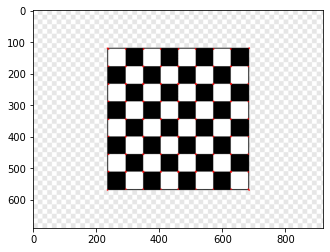

In [9]:


filename = '/content/png-transparent-chessboard-mathematics-board-game-chess-game-symmetry-black.png'
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[255,0,0]

plt.imshow(img)

plt.show()

# Corner with SubPixel Accuracy

Sometimes, you may need to find the corners with maximum accuracy. OpenCV comes with a function cv2.cornerSubPix() which further refines the corners detected with sub-pixel accuracy. Below is an example. As usual, we need to find the harris corners first. Then we pass the centroids of these corners (There may be a bunch of pixels at a corner, we take their centroid) to refine them. Harris corners are marked in red pixels and refined corners are marked in green pixels. For this function, we have to define the criteria when to stop the iteration. We stop it after a specified number of iteration or a certain accuracy is achieved, whichever occurs first. We also need to define the size of neighbourhood it would search for corners.

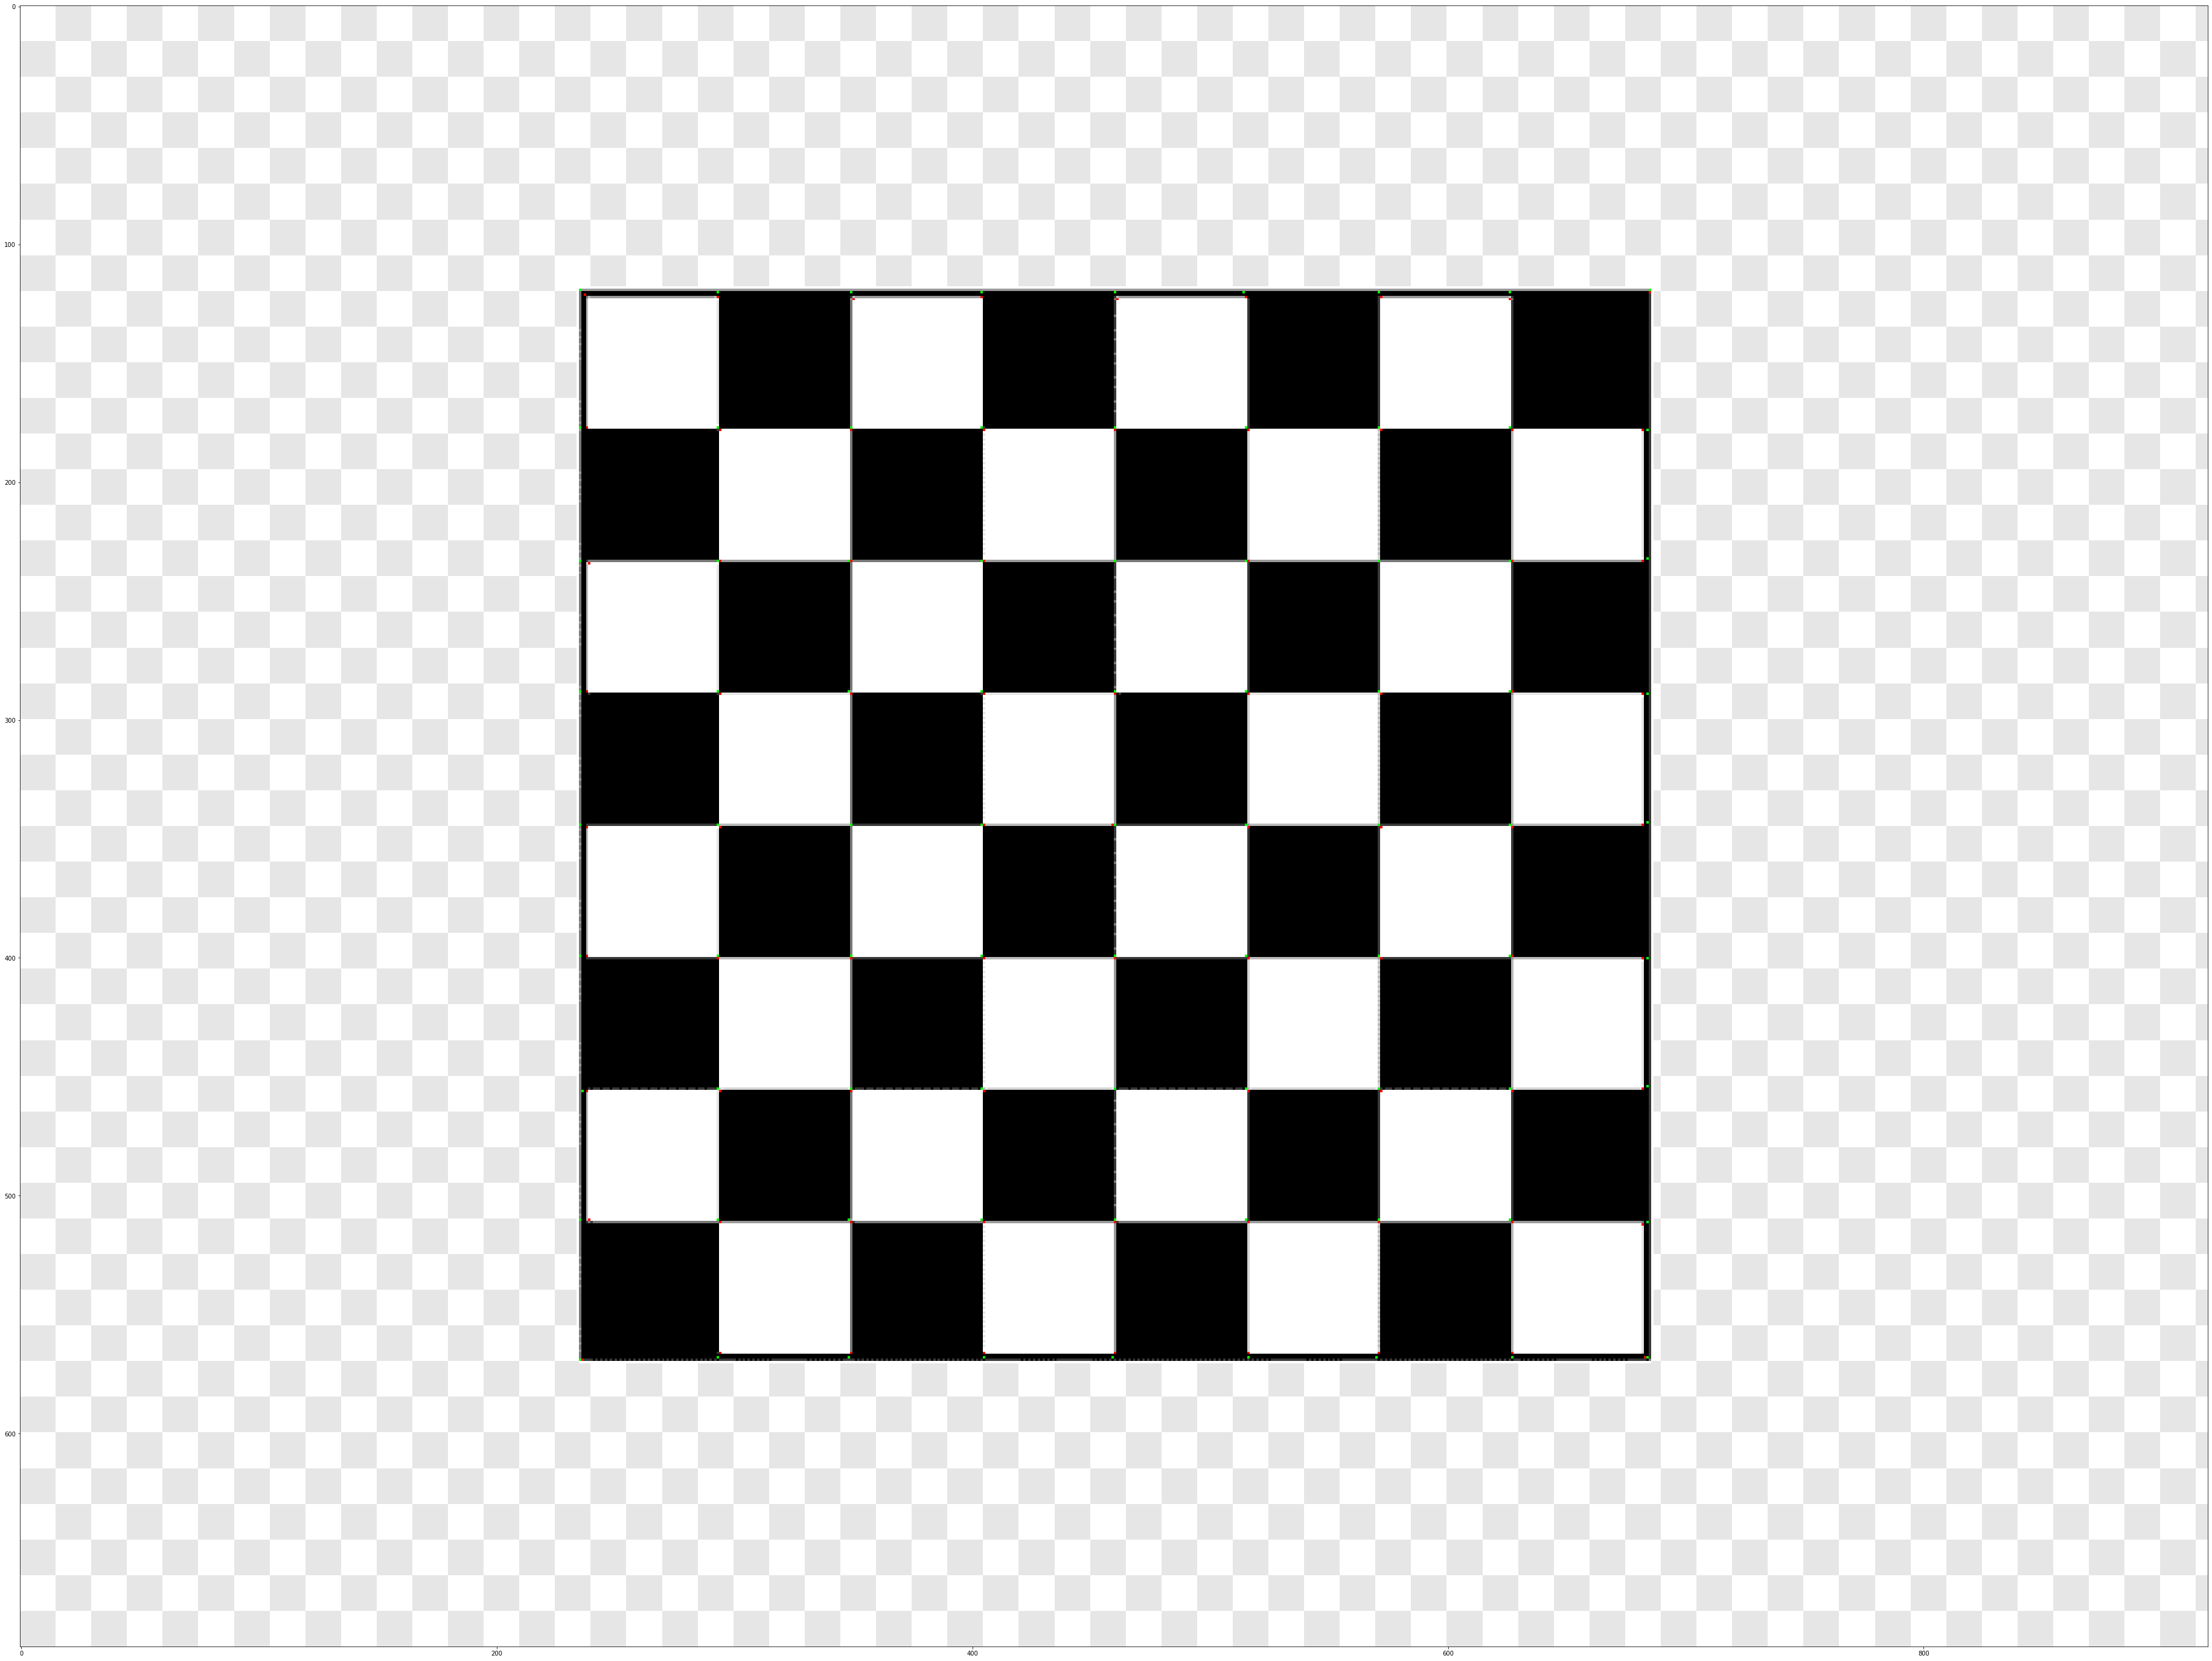

In [15]:
plt.rcParams['figure.figsize'] = [100, 50]
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# find Harris corners
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[255,0,0]
img[res[:,3],res[:,2]] = [0,255,0]

plt.imshow(img)
plt.show()